In [42]:
%pip install pandas
%pip install openpyxl
%pip install scikit-learn
%pip install matplotlib


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 7.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.6 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.3/249.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 4.5 MB/s eta 

In [39]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

###############################################################################
# PART A: AUTOMATED METADATA SCAN TO BUILD DROP LISTS
###############################################################################
# Load metadata files from the Documentation folder.
demo_change_list = pd.read_csv("Documentation/DemoStats 2024 - Variables Change List.csv")
demo_list = pd.read_csv("Documentation/DemoStats 2024 - Variables List.csv")
household_change_list = pd.read_excel("Documentation/HouseholdSpend 2024 - Variables Change List.xlsx")
household_list = pd.read_excel("Documentation/HouseholdSpend 2024 - Variables List.xlsx")

# Define search keywords.
search_terms = ["pension", "retirement", "insurance"]

# Function to search for keywords in given columns.
def find_keywords(df, cols, terms):
    results = []
    for _, row in df.iterrows():
        for col in cols:
            val = str(row.get(col, "")).lower()
            for term in terms:
                if term in val:
                    results.append(row.get("Variable", ""))
    return results

# Search each metadata file.
demo_pens_1 = find_keywords(demo_change_list, ["Variable", "Description", "Category"], search_terms)
demo_pens_2 = find_keywords(demo_list, ["Variable", "Description", "Hierarchy Description", "Category"], search_terms)
house_pens_1 = find_keywords(household_change_list, ["Variable", "Description", "Category"], search_terms)
house_pens_2 = find_keywords(household_list, ["Variable", "Description", "Category", "Consumption"], search_terms)

# Build drop lists for pension/retirement/insurance columns.
demo_pens_vars = sorted(set(demo_pens_1 + demo_pens_2))
house_pens_vars = sorted(set(house_pens_1 + house_pens_2))

# Find "No Longer Available" variables.
demo_no_longer = demo_change_list[
    demo_change_list["Change Type"].str.lower().str.contains("no longer available")
]["Variable"].unique().tolist()
house_no_longer = household_change_list[
    household_change_list["Change Type"].str.lower().str.contains("no longer available")
]["Variable"].unique().tolist()

# Build the final drop lists.
demo_all_drops = sorted(set(demo_pens_vars + demo_no_longer))
house_all_drops = sorted(set(house_pens_vars + house_no_longer))

print("DemoStats drop list:", demo_all_drops)
print("HouseholdSpend drop list:", house_all_drops)

###############################################################################
# PART B: LOAD ORIGINAL DATA, DROP UNWANTED COLUMNS, MERGE, AND SAMPLE
###############################################################################
# Load the original data files from the Coursework Data folder.
df_demo_orig = pd.read_csv("Coursework Data/Demostats.csv")
df_household_orig = pd.read_csv("Coursework Data/HouseholdSpend.csv")

# Drop the automatically discovered columns.
df_demo_clean = df_demo_orig.drop(columns=demo_all_drops, errors="ignore")
df_household_clean = df_household_orig.drop(columns=house_all_drops, errors="ignore")

# Merge on ["GEO", "CODE"].
df_merged = pd.merge(df_demo_clean, df_household_clean, on=["GEO", "CODE"], how="inner")
df_merged.drop_duplicates(inplace=True)
print("Merged shape:", df_merged.shape)

# Sample 100,000 rows for manageable processing.
df_sample = df_merged.sample(n=100000, random_state=42)
print("Sample shape:", df_sample.shape)

###############################################################################
# PART C: NUMERIC CLEANING
###############################################################################
# Drop columns with over 80% missing values.
missing_pct = df_sample.isnull().mean()
cols_to_drop = missing_pct[missing_pct > 0.8].index.tolist()
df_sample.drop(columns=cols_to_drop, inplace=True, errors="ignore")
print("Shape after dropping high-missingness columns:", df_sample.shape)

# Separate numeric and non-numeric columns.
df_numeric = df_sample.select_dtypes(include=[np.number])
df_non_numeric = df_sample.select_dtypes(exclude=[np.number])

# Median impute numeric columns.
imputer = SimpleImputer(strategy="median")
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric),
                                  columns=df_numeric.columns,
                                  index=df_numeric.index)

# Drop near-constant numeric columns (std < 1e-6).
const_cols = df_numeric_imputed.std()[df_numeric_imputed.std() < 1e-6].index.tolist()
df_numeric_imputed.drop(columns=const_cols, inplace=True)

# Winsorize numeric columns using IQR (cap outliers).
def winsorize_IQR(df, multiplier=1.5):
    df_w = df.copy()
    for col in df_w.columns:
        Q1 = df_w[col].quantile(0.25)
        Q3 = df_w[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - multiplier * IQR
        high = Q3 + multiplier * IQR
        df_w[col] = df_w[col].clip(lower=low, upper=high)
    return df_w

df_numeric_winsorized = winsorize_IQR(df_numeric_imputed, multiplier=1.5)

# Standard scale the numeric columns.
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric_winsorized),
                                 columns=df_numeric_winsorized.columns,
                                 index=df_numeric_winsorized.index)

# Reattach non-numeric columns.
df_non_numeric_filtered = df_non_numeric.loc[df_numeric_scaled.index]
df_final_for_clustering = pd.concat([df_non_numeric_filtered, df_numeric_scaled], axis=1)

print("Final shape for clustering:", df_final_for_clustering.shape)
print(df_final_for_clustering.head())


DemoStats drop list: ['ECYCFSC1C', 'ECYCFSC2C', 'ECYCFSC3C', 'ECYCFSCL1C', 'ECYCFSCL2C', 'ECYCFSCL3C', 'ECYCFSFP1C', 'ECYCFSFP2C', 'ECYCFSFP3C', 'ECYCFSLP1C', 'ECYCFSLP2C', 'ECYCFSLP3C', 'ECYCFSM1C', 'ECYCFSM2C', 'ECYCFSM3C', 'ECYCFSMP1C', 'ECYCFSMP2C', 'ECYCFSMP3C', 'ECYHFSC1C', 'ECYHFSC2C', 'ECYHFSC3C', 'ECYHFSCL1C', 'ECYHFSCL2C', 'ECYHFSCL3C', 'ECYHFSFP1C', 'ECYHFSFP2C', 'ECYHFSFP3C', 'ECYHFSLP1C', 'ECYHFSLP2C', 'ECYHFSLP3C', 'ECYHFSM1C', 'ECYHFSM2C', 'ECYHFSM3C', 'ECYHFSMP1C', 'ECYHFSMP2C', 'ECYHFSMP3C', 'ECYINDFINA', 'ECYMTN75P', 'ECYPIM0105', 'ECYPIM0610', 'ECYPIM1116', 'ECYPIM17CY', 'EHYCFSC1C', 'EHYCFSC2C', 'EHYCFSC3C', 'EHYCFSCL1C', 'EHYCFSCL2C', 'EHYCFSCL3C', 'EHYCFSFP1C', 'EHYCFSFP2C', 'EHYCFSFP3C', 'EHYCFSLP1C', 'EHYCFSLP2C', 'EHYCFSLP3C', 'EHYCFSM1C', 'EHYCFSM2C', 'EHYCFSM3C', 'EHYCFSMP1C', 'EHYCFSMP2C', 'EHYCFSMP3C', 'EHYHFSC1C', 'EHYHFSC2C', 'EHYHFSC3C', 'EHYHFSCL1C', 'EHYHFSCL2C', 'EHYHFSCL3C', 'EHYHFSFP1C', 'EHYHFSFP2C', 'EHYHFSFP3C', 'EHYHFSLP1C', 'EHYHFSLP2C', 'EHYHF

Matplotlib is building the font cache; this may take a moment.


k = 2: Inertia = 32255758.29, Silhouette Score = 0.497
k = 3: Inertia = 26057977.13, Silhouette Score = 0.317
k = 4: Inertia = 23889292.57, Silhouette Score = 0.224
k = 5: Inertia = 22948666.77, Silhouette Score = 0.163
k = 6: Inertia = 22277476.12, Silhouette Score = 0.150
k = 7: Inertia = 21581512.73, Silhouette Score = 0.134
k = 8: Inertia = 20975751.57, Silhouette Score = 0.131
k = 9: Inertia = 20518042.00, Silhouette Score = 0.132
k = 10: Inertia = 20136721.68, Silhouette Score = 0.134


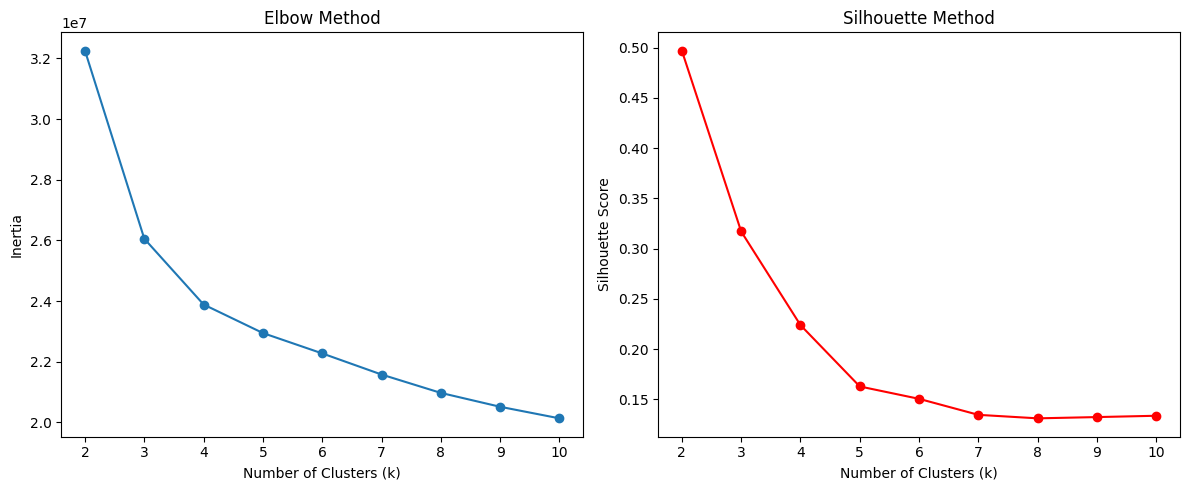

In [43]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assume df_final_for_clustering is your cleaned DataFrame from Part 1.
# Use only the numeric columns for clustering:
X = df_final_for_clustering.select_dtypes(include=[np.number])

# Define a range for the number of clusters to test.
cluster_range = range(2, 11)  # Testing for k=2 to k=10 clusters.
inertias = []           # For the elbow method.
silhouette_scores = []  # For the silhouette method.

# Run KMeans for each k, record the inertia and silhouette score.
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"k = {k}: Inertia = {kmeans.inertia_:.2f}, Silhouette Score = {sil_score:.3f}")

# Plot the results: elbow plot (inertia vs. number of clusters)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(cluster_range), inertias, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot the silhouette score vs. number of clusters.
plt.subplot(1, 2, 2)
plt.plot(list(cluster_range), silhouette_scores, marker='o', linestyle='-', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")

plt.tight_layout()
plt.show()


# Optimal Number of Clusters: Elbow & Silhouette Methods

To determine the optimal number of clusters, two methods were employed:

## Elbow Method (Inertia)
The *inertia* is defined as the sum of squared distances between samples and their nearest cluster centroid. In this analysis, inertia was calculated for various values of \( k \) (from 2 to 10 clusters). The results indicate:

- A significant drop in inertia is observed when moving from \( k = 2 \) (inertia ≈ 32,255,758) to \( k = 3 \) (inertia ≈ 26,057,977).
- Beyond \( k = 3 \), the rate of decrease in inertia diminishes, which suggests that adding more clusters yields progressively smaller improvements in explaining data variance.

In general, one seeks an “elbow” in the inertia plot—a point where further increases in \( k \) do not lead to substantial reductions in inertia. In this case, the elbow appears around \( k = 3 \) or possibly \( k = 4 \).

## Silhouette Method
The *silhouette score* measures how similar an object is to its own cluster compared to other clusters, with values ranging from \(-1\) to \( 1 \). A higher silhouette score indicates better-defined, more distinct clusters. According to the results:

- The highest silhouette score is achieved at \( k = 2 \) (0.497).
- The silhouette score drops significantly to 0.317 at \( k = 3 \) and declines further as \( k \) increases.

This indicates that, in terms of cluster separation, a 2-cluster solution produces the most distinct grouping of data points.

## Conclusion
The two methods provide somewhat different recommendations:

- The **Elbow Method** suggests that additional clusters (around \( k = 3 \) or \( k = 4 \)) reduce inertia, but with diminishing returns.
- The **Silhouette Method** clearly favors a 2-cluster solution due to the highest average silhouette score.

**Formal Conclusion:**  
If the primary objective is to obtain well-separated, distinct clusters, the silhouette analysis indicates that \( k = 2 \) is optimal. However, if a finer segmentation is desired—even though it results in lower silhouette scores—one might choose \( k = 3 \) (or \( k = 4 \)). In this case, the evidence leans towards a 2-cluster solution as it yields the highest silhouette score, thereby indicating clearer separation between clusters.


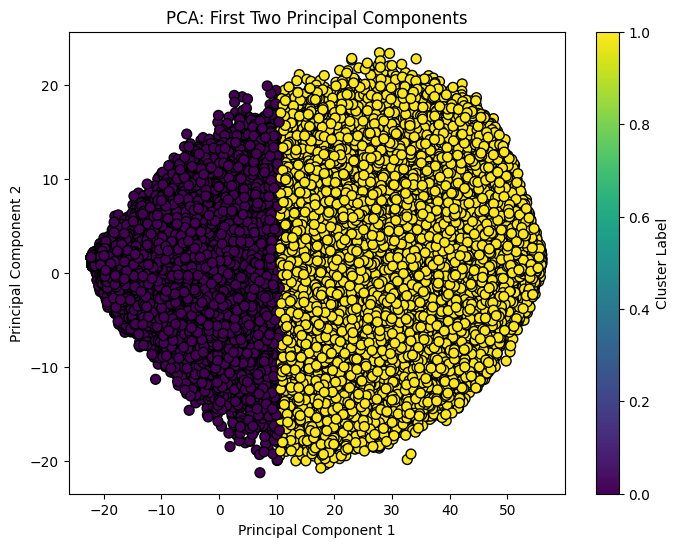

Explained Variance Ratio for the first 3 Principal Components:
[0.67331054 0.03763894 0.03145207]

PCA Components (Loadings) for the first 3 Principal Components:
     ECYBASPOP  ECYBASHHD  ECYBASHPOP  ECYBAS12P  ECYBAS15P  ECYBAS18P  \
PC1   0.046244   0.045662    0.046662   0.046159   0.046130   0.046084   
PC2   0.021031   0.029457    0.020655   0.021533   0.021755   0.022933   
PC3   0.001349   0.034959   -0.000306   0.003295   0.004524   0.006176   

     ECYBAS19P  ECYBAS12HP  ECYBAS15HP  ECYBAS18HP  ...   HSTR050   HSTR051  \
PC1   0.046075    0.046646    0.046631    0.046600  ...  0.043388  0.036509   
PC2   0.022865    0.020125    0.020492    0.021460  ...  0.003131  0.052242   
PC3   0.007032    0.002081    0.003116    0.004849  ... -0.028481 -0.037802   

      HSTR052   HSTR053   HSTR054   HSTR055   HSTR056  HSTR056A  HSTR056B  \
PC1  0.040824  0.030813  0.043026  0.038223  0.038568  0.036328  0.034262   
PC2  0.028310 -0.004117 -0.012020  0.042098 -0.012257 -0.022709 -0.00

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Assume df_final_for_clustering is already defined from Part 1 (the cleaned data)
# We use only the numeric portion for PCA.
X = df_final_for_clustering.select_dtypes(include=[np.number])

# Run K-Means clustering with the optimal k, here we choose k = 2 based on silhouette scores.
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)

# Apply PCA to reduce the dimensionality to 3 principal components.
pca = PCA(n_components=3, random_state=42)
pca_result = pca.fit_transform(X)

# Plot the first two principal components, coloring points by cluster label.
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Principal Components")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Print out the explained variance ratio for the first 3 components.
print("Explained Variance Ratio for the first 3 Principal Components:")
print(pca.explained_variance_ratio_)

# Print out the PCA loadings (components) for the first 3 components.
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2', 'PC3'])
print("\nPCA Components (Loadings) for the first 3 Principal Components:")
print(pca_components)


## 1(c)(ii): Interpretation of PCA Results

After applying PCA to the cleaned numeric data, we obtained the following results for the first three principal components:

**Explained Variance Ratios:**

- **PC1:** 67.33%  
- **PC2:** 3.76%  
- **PC3:** 3.15%

This indicates that the first principal component (PC1) accounts for the majority of the variance in the dataset, capturing approximately two-thirds of the total variability. In contrast, PC2 and PC3 explain a much smaller proportion of the variance, suggesting that the primary structure in the data is dominated by the variation along PC1.

**PCA Loadings (Components) for the First 3 Components:**  

The loadings for the first three components are as shown below (only a subset of the variables is displayed for brevity):

|        | ECYBASPOP | ECYBASHHD | ECYBASHPOP | ECYBAS12P | ECYBAS15P | ECYBAS18P | … | HSTR056B | HSTR057 |
|--------|-----------|-----------|------------|-----------|-----------|-----------|---|----------|---------|
| **PC1** | 0.046244  | 0.045662  | 0.046662   | 0.046159  | 0.046130  | 0.046084  | … | 0.034262 | 0.042071|
| **PC2** | 0.021031  | 0.029457  | 0.020655   | 0.021533  | 0.021755  | 0.022933  | … | -0.000643| 0.002144|
| **PC3** | 0.001349  | 0.034959  | -0.000306  | 0.003295  | 0.004524  | 0.006176  | … | 0.024913 | -0.005095|

**Interpretation:**

1. **Dominance of PC1:**  
   - The high explained variance ratio (67.33%) and the similar loadings across most variables for PC1 indicate that this component represents an overall aggregate measure capturing the principal source of variation in the data. Nearly all variables contribute similarly to PC1, which suggests that it may reflect a general magnitude or scale effect common to many features (for example, overall population or overall activity levels).

2. **Role of PC2 and PC3:**  
   - PC2 and PC3 together explain only about 7% of the variance (3.76% + 3.15%). Their loadings are more varied, with some features contributing positively and others negatively. This indicates that while these components capture secondary patterns in the data, they do not have as much influence in distinguishing the clusters as PC1 does.
   - The relatively low explained variance of PC2 and PC3 is consistent with the clustering results (which favored a 2-cluster solution largely driven by the dominant variation in PC1).

3. **Implication for Cluster Separation:**  
   - Given that PC1 encapsulates most of the variance, the distinct separation observed along this axis in the PCA scatter plot underpins the high silhouette score for \( k = 2 \) clusters. The additional components (PC2 and PC3) capture residual variability, which may contain nuances but does not significantly enhance cluster differentiation.

**Conclusion:**

The PCA output validates the earlier clustering results by showing that the main structure in the data is captured by PC1, which supports a 2-cluster solution. While PC2 and PC3 reveal additional minor patterns, they contribute relatively little to the overall variance. Therefore, the data naturally segregates into two distinct groups, with most of the informative variation concentrated along a single dominant axis.


In [45]:
# Convert the PCA results to a DataFrame:
df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"], index=X.index)

# Add the cluster labels:
df_pca["Cluster"] = labels

# Compute the average values for each cluster:
cluster_avgs = df_pca.groupby("Cluster").mean()
print(cluster_avgs)

               PC1       PC2       PC3
Cluster                               
0       -10.783862 -0.022716  0.077712
1        31.734225  0.066846 -0.228687


## 1(c)(iii): Average Principal Component Values by Cluster and Cluster Naming

After performing PCA on the cleaned clustering data and applying K‑Means clustering with \( k = 2 \), the average values of the first three principal components for each cluster were computed. The results are summarized in the table below:

| Cluster |     PC1     |    PC2    |    PC3    |
|---------|-------------|-----------|-----------|
|   0     |  -10.78    |   -0.02   |   0.08    |
|   1     |   31.73    |    0.07   |  -0.23    |

### Interpretation

- **PC1:**  
  The first principal component (PC1) captures approximately 67.33% of the variance in the data. The large difference between the clusters (with an average of about -10.78 for Cluster 0 and 31.73 for Cluster 1) indicates that PC1 is the dominant factor separating the two groups. This suggests that the set of variables loading highly on PC1 is responsible for a strong overall contrast between clusters.

- **PC2 and PC3:**  
  Both PC2 (3.76% variance) and PC3 (3.15% variance) contribute very little relative to PC1. The small differences in these components between clusters imply that they capture secondary or more nuanced aspects of variability, which have less impact on the overall separation of clusters.

### Cluster Naming

Based on the results:

- **Cluster 1 ("High Overall Measures"):**  
  Cluster 1 exhibits a high average PC1 score (31.73), which, given that PC1 is the dominant source of variation, suggests that the features contributing to PC1 are elevated in this group. These features might represent higher values in overall socioeconomic indicators, demographic magnitude, or related variables.  
- **Cluster 0 ("Low Overall Measures"):**  
  Cluster 0 shows a lower average PC1 score (-10.78), indicating that the underlying attributes are generally lower compared to Cluster 1.

### Conclusion

The analysis of average principal component scores confirms that the primary separation between the clusters is driven by PC1. While PC2 and PC3 provide additional information, their contribution to cluster differentiation is minor. Accordingly, the data naturally segregates into two distinct groups, which we label as “High Overall Measures” (Cluster 1) and “Low Overall Measures” (Cluster 0), reflecting the key underlying differences in the dominant features.
